### Load required libraries and data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/Users/peterfoster/Desktop/Profile_Fitting_Simulations') ## Put the folder in which contract
import contract 
from scipy.integrate import odeint

simu_length=20.
simu_points=2000.

ngp=256

In [3]:
##LOAD THE DENSITY DATA HERE
from scipy.io import loadmat
f=loadmat('Fixed_Profiles.mat')
pp=f['Profile']

In [4]:
##LOAD VELOCITY DATA HERE
from scipy.io import loadmat
f=loadmat('Velocity_timecourse.mat')
xt=f['Position_timecourse'].flatten()
xt=[xx[0] for xx in xt]


vt=f['Velocity_timecourse']
vt=[xx.flatten() for xx in vt[0]]

### Define compute and plot functions

In [5]:
## Defines how the time evolution is done.
def compute(a,b,r0,w_init=None):
    l=sqrt(a/b)
    s0=-1./sqrt(a*b)
    
    #if no w_init is given take it from movie
    if w_init==None:
        ww=[i  for i in xrange(206) if not isnan(pp[0,i])]
        w_init=max(ww)-min(ww)
        w_init=w_init*8.
        
    #set parameters
    contract.l=l
    contract.s0=s0
    contract.rho0=1.
    contract.rho_init=r0*ones(ngp)
    contract.w_init=w_init

    t=linspace(0,simu_length,simu_points)

    return odeint(contract.dt_packed,contract.init_packed(),t)

In [6]:
def normalization():
        ##obtain width of first experimental frame
    ww=[i  for i in xrange(206) if not isnan(pp[0,i])]
    w_init=max(ww)-min(ww)
    w_init=w_init*8.
    
    ##obtain experimental mean level in the first frame
    ppc=[i for i in xrange(206) if not isnan(pp[0][i])]
    pm=mean(ppc)
    exp_mean0=mean([pp[0,i] for i in ppc])*w_init
    
    ##obtain theory mean level in the frame cooresponding to the first experimental frame
    th_mean0=mean(o[0][1:ngp+1])*o[0][0]
    
    return th_mean0/exp_mean0
    
  

In [7]:
##This defines the plotting routine
##frames are the frames which you wish to show
##offset omit the first offset frames (this is to get rid of the initial lag phase)
def and_plot_velocity(frames=(0,10,15,25,30),framerate=3.,offset=0):
      
    ##obtain time offset between simulation and experiment 
    simu_frame_offset=offset/simu_length*simu_points

    r=normalization()
    
    colors={0:'r',1:'g',2:'b'}
    c=0
    
    for j in frames:
        #pick simulation frame to be shown 
        #(Here the total sim length is div minutes with 2000 time points stored)
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset
        
        #center data to show
        #ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
        #pm=mean(ppc)
        
        #plot
        #plot((arange(206)-pm)*8,pp[j],'-',color=colors[c])
        
        if k>=0:
            v=contract.get_v(o[k][0],o[k][1:])
            plot(linspace(0,o[k][0]/2.,ngp),v,'--',lw=3,color=colors[c])
            plot(linspace(0,-o[k][0]/2.,ngp),-v,'--',lw=3,color=colors[c])
            #xlim(-650, 650)
            #ylim(.0055, .0185)
        #pick new color for the next curve
        c=(c+1)%3



In [8]:
##This defines the plotting routine
##frames are the frames which you wish to show
##offset omit the first offset frames (this is to get rid of the initial lag phase)
def and_plot(frames=(0,10,15,25,30),framerate=3.,offset=0):
      
    ##obtain time offset between simulation and experiment 
    simu_frame_offset=offset/simu_length*simu_points

    r=normalization()
    
    colors={0:'r',1:'g',2:'b'}
    c=0
    
    for j in frames:
        #pick simulation frame to be shown 
        #(Here the total sim length is div minutes with 2000 time points stored)
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset
        
        #center data to show
        ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
        pm=mean(ppc)
        
        #plot
        plot((arange(206)-pm)*8,pp[j],'-',color=colors[c])
        
        if k>=0:
            plot(linspace(0,o[k][0]/2.,ngp),o[k][1:]/r,'--',lw=3,color=colors[c])
            plot(linspace(0,-o[k][0]/2.,ngp),o[k][1:]/r,'--',lw=3,color=colors[c])
            xlim(-650, 650)
#             ylim(.0055, .0185)
        #pick new color for the next curve
        c=(c+1)%3



### Plot from Peters manualy determined best fit values

In [9]:
a,b,r0=array([  2.26413429e+00,   7.09505347e-05,   3.26194452e-01]) #
## these are the values coming from a leastsq procedure
a=a/3.
b=b/3.

b=b/4.

o=compute(a,b,r0,w_init=647*2)
#and_plot(offset=0.,frames=(0,6,12,18))

/Users/peterfoster/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:90: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


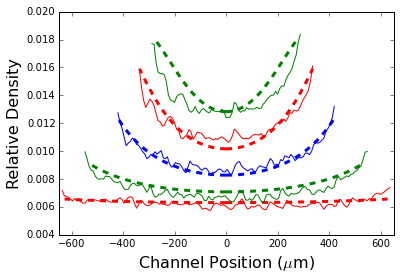

In [10]:
and_plot(offset=-0.8,frames=(3,6,9,12,15))
#savefig('/Users/peterfoster/Desktop/Profile_Fitting_Simulations/offsetcorrected.eps') ### CHANGE FOLDER NAME IN THIS LINE
#ylim(0.005,.020)
#xlim(-1000,1000)
xlabel('Channel Position ($\mu$m)', size=16)
ylabel('Relative Density', size=16)

### Confirm by doing least squares fit

In [11]:
def fit_fun(args):
    offset=-0.4
    framerate=3.
    simu_frame_offset=offset/simu_length*simu_points
    from scipy.interpolate import interp1d
    o=compute(*args,w_init=2*694)
    oo=[]
    #ppc=[i for i in xrange(206) if not isnan(pp[0][i])]
    #pv=mean([pp[0,i]for i in ppc])
    
    r=normalization()
    
    for j in range(0,15):
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset
        if k>=0:
            #wrap data in function
            ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
            pm=mean(ppc)
            p=nan_to_num(pp[j])
            x=(arange(206)-pm)*8
            data=interp1d((arange(206)-pm)*8,p)
            edat=data(x)

            #wrap theory result
            xt=linspace(0,o[k][0]/2.,ngp)
            yt=o[k][1:ngp+1]/r
            theory=interp1d(xt,yt)
            tdat=[]
            for xx in x:
                try: 
                    tdat.append(theory(abs(xx)))
                except:
                    tdat.append(0.)

            tdat=array(tdat)

            oo.append(tdat-edat)

        
    return array(oo).flatten()
    
oo=fit_fun((a,b,r0))

In [12]:
from scipy.optimize import leastsq,fmin
best_fit=leastsq(fit_fun,(a,b,r0))
print best_fit

(array([  9.00036043e-01,   3.73472775e-06,   3.03218838e-01]), 2)


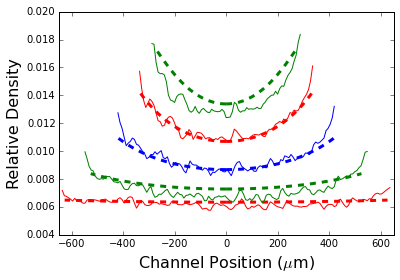

In [13]:
a,b,r0=best_fit[0]
o=compute(a,b,r0,w_init=2*647)
and_plot(offset=-0.8,frames=(3,6,9,12,15))
xlabel('Channel Position ($\mu$m)', size=16)
ylabel('Relative Density', size=16)

savefig('/Users/peterfoster/Desktop/Profile_Fitting_Simulations/supp_density8_14_8_5extract_slide2_fit3.pdf')
       

### Also plot velocities

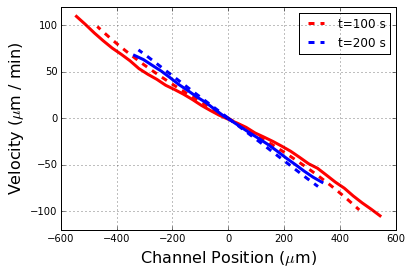

In [14]:

offset=-.4+.5
framerate=3.

simu_frame_offset=offset/simu_length*simu_points

r=normalization()

colors={0:'r',1:'b',2:'g'}
c=0

for j in (5,10):
    #pick simulation frame to be shown 
    #(Here the total sim length is div minutes with 2000 time points stored)
    k=(j)/framerate/simu_length*simu_points+simu_frame_offset
    
    plot(xt[j]-mean(xt[j]),(vt[j]-mean(vt[j])),'-', lw=3.,color=colors[c])

    if k>=0:
        v=contract.get_v(o[k][0],o[k][1:])
        plot(linspace(0,o[k][0]/2.,ngp),v,'--',lw=3,color=colors[c],label='t=%i s'%(j*20))
        plot(linspace(0,-o[k][0]/2.,ngp),-v,'--',lw=3,color=colors[c])
        #xlim(-650, 650)
        #ylim(.0055, .0185)
    #pick new color for the next curve
    c=(c+1)%3
    legend()
    
    
grid()
ylim(-120,120)
xlabel('Channel Position ($\mu$m)', size=16)
ylabel('Velocity ($\mu$m / min)', size=16)


savefig('/Users/peterfoster/Desktop/Profile_Fitting_Simulations/supp_velocity.pdf')


### Redo the fits including offset and initial width

In [15]:
def fit_fun2(args):
    a,b,r0,offset,w_init=args
    framerate=3.
    simu_frame_offset=offset/simu_length*simu_points
    from scipy.interpolate import interp1d
    #o=compute(a,b,r0,w_init=w_init)
    o=compute(a,b,r0,w_init=2*694)

    oo=[]
    #ppc=[i for i in xrange(206) if not isnan(pp[0][i])]
    #pv=mean([pp[0,i]for i in ppc])
    r=normalization()
    
    for j in range(0,30):
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset
        if k>=0:
            #wrap data in function
            ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
            pm=mean(ppc)
            p=nan_to_num(pp[j])
            x=(arange(206)-pm)*8
            data=interp1d((arange(206)-pm)*8,p)
            edat=data(x)

            #wrap theory result
            xt=linspace(0,o[k][0]/2.,ngp)
            yt=o[k][1:ngp+1]/r
            theory=interp1d(xt,yt)
            tdat=[]
            for xx in x:
                try: 
                    tdat.append(theory(abs(xx)))
                except:
                    tdat.append(0.)

            tdat=array(tdat)

            oo.append(tdat-edat)

        
    return array(oo).flatten()
    
#oo=fit_fun2((a,b,r0,-0,2.*450))

In [16]:
from scipy.optimize import leastsq,fmin
#a,b,r0=array([   0.8,   1.3e-05,   0.3]) ### these are the values coming from a leastsq procedure
a,b,r0=array([    9.00036043e-01,   3.73472775e-06,   3.03218838e-01]) ### these are the values coming from a leastsq procedure

best_fit2=leastsq(fit_fun2,(a,b,r0,-.4,2*694),maxfev=10000000,xtol=1.49012e-12,ftol=1.49012e-12,epsfcn=1.0e-3)
print best_fit2

(array([  9.63734407e-01,   3.74794257e-06,   3.21307132e-01,
        -4.27356850e-01,   1.38800000e+03]), 2)


0.32130713238


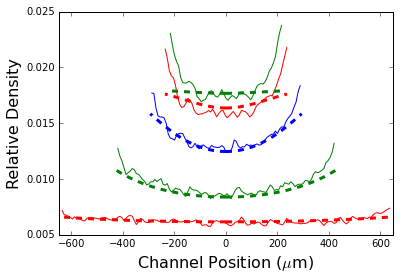

In [17]:
a,b,r0,offset,w_init=best_fit2[0]

print r0
o=compute(a,b,r0,w_init=w_init)
#offset=-.4
and_plot(offset=offset,frames=(3,9,15,21,27))
xlabel('Channel Position ($\mu$m)', size=16)
ylabel('Relative Density', size=16)

savefig('/Users/peterfoster/Desktop/Profile_Fitting_Simulations/FigS1.eps')

In [18]:
# from scipy.optimize import leastsq
# leastsq?


In [19]:

# offset=offset + 1/6
# framerate=3.

# simu_frame_offset=offset/simu_length*simu_points

# r=normalization()

# colors={0:'r',1:'b',2:'g'}
# c=0

# for j in (5,10):
#     #pick simulation frame to be shown 
#     #(Here the total sim length is div minutes with 2000 time points stored)
#     k=(j)/framerate/simu_length*simu_points+simu_frame_offset
    
#     plot(xt[j]-mean(xt[j]),(vt[j]-mean(vt[j])),'-', lw=3.,color=colors[c])

#     if k>=0:
#         v=contract.get_v(o[k][0],o[k][1:])
#         plot(linspace(0,o[k][0]/2.,ngp),v,'--',lw=3,color=colors[c],label='t=%i s'%(j*20))
#         plot(linspace(0,-o[k][0]/2.,ngp),-v,'--',lw=3,color=colors[c])
#         #xlim(-650, 650)
#         #ylim(.0055, .0185)
#     #pick new color for the next curve
#     c=(c+1)%3
#     legend()
    
    
# grid()
# ylim(-120,120)
# xlabel('Channel Position ($\mu$m)', size=16)
# ylabel('Velocity ($\mu$m / min)', size=16)


# savefig('/Users/peterfoster/Desktop/Profile_Fitting_Simulations/supp_velocity_Fig4d.eps')

In [42]:
def make_movie_velocity(frame_max=30,folder='/Users/peterfoster/Desktop/Profile_Fitting_Simulations/velocity_movie/',framerate=3.,offset=-0.4): 
    
    simu_frame_offset=offset/simu_length*simu_points
    r=normalization()
    
    for j in xrange(frame_max):
        #pick simulation frame to be shown 
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset

        #plot(xt[j]-mean(xt[j]),(vt[j]-mean(vt[j])),'-', lw=3.,color='r')
        #center data to show
        ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
        pm=mean(ppc)
        
        #plot

        if k>=0:
            v=contract.get_v(o[k][0],o[k][1:])
            plot(linspace(0,o[k][0]/2.,ngp),o[k][1:]/r,lw=4,color='b')
            plot(linspace(0,-o[k][0]/2.,ngp),o[k][1:]/r,lw=4,color='b')
            ylim(0,0.02)
            xlim(-700, 700)

            #ylabel('Relative Density', size=16)

            twinx()
            
            plot(linspace(0,o[k][0]/2.,ngp),v,'--',lw=3,color='r')
            plot(linspace(0,-o[k][0]/2.,ngp),-v,'--',lw=3,color='r')
            #xlim(-650, 650)
            #ylim(.0055, .0185)
        #pick new color for the next curve
        grid()
        ylim(-120,120)
        xlim(-700, 700)
        #xlabel('Channel Position ($\mu$m)', size=16)
        #ylabel('Velocity ($\mu$m / min)', size=16)

        fname=folder+'fig_v_%03i.png'%j
        savefig(fname)
        clf()
        
make_movie_velocity()

In [29]:
def make_movie_density(frame_max=30,folder='/Users/peterfoster/Desktop/Profile_Fitting_Simulations/data_overlap_movie/',framerate=3.,offset=-0.4): 
    
    simu_frame_offset=offset/simu_length*simu_points
    r=normalization()
    
    for j in xrange(frame_max):
        #pick simulation frame to be shown 
        k=(j)/framerate/simu_length*simu_points+simu_frame_offset
        
        #center data to show
        ppc=[i for i in xrange(206) if not isnan(pp[j][i])]
        pm=mean(ppc)
        
        #plot
        plot((arange(206)-pm)*8,pp[j],'-',lw=3,color='b')
        twinx()
        if k>=0:

            plot(linspace(0,o[k][0]/2.,ngp),o[k][1:]/r,'--',lw=4,color='r')
            plot(linspace(0,-o[k][0]/2.,ngp),o[k][1:]/r,'--',lw=4,color='r')

            xlim(-650, 650)
            ylim(.0055, .02)
            xlabel('Channel Position ($\mu$m)', size=16)
            ylabel('Relative Density', size=16)
        fname=folder+'fig_rho_%03i.png'%j
        savefig(fname)
        clf()
        
make_movie_density()